In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import time
import pickle
from random import random, shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
# custom libraries created for this project
import p5library
import importlib
importlib.reload(p5library)
from p5library import *
%matplotlib inline

In [30]:
cars = glob.glob('training/vehicles/**/*.png', recursive=True)
notcars = glob.glob('training/non-vehicles/**/*.png', recursive=True)

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8870  non-cars
of size:  (64, 64, 3)  and data type: float32


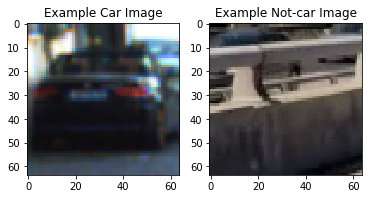

In [4]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [3]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


In [32]:
car_images = get_images(cars)
notcar_images = get_images(notcars)

print('car samples: {}, notcar samples: {}'.format(len(car_images), len(notcar_images)))

car samples: 17584, notcar samples: 17740


In [33]:
t=time.time()
    
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

349.97 Seconds to extract features...


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# with open('data.pickle', 'rb') as handle:
#     data1 = pickle.load(handle)
#X = data[0]
#y = data[1]

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
print(X_train.shape)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

(28259, 1680)
Using: 8 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1680


In [37]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time

# Use a linear SVC 
# svc = LinearSVC(C = 100.)
svc = SVC(C=10)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Training Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print('Test accuracy time (sec): {}'.format(round(t-t2, 2)))

597.23 Seconds to train SVC...
Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9982
Test accuracy time (sec): 405.13


In [38]:
data = [svc, X_scaler]
with open('model_ycrcb_rbf.pickle','wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open('model_ycrcb_rbf.pickle', 'rb') as handle:
    data = pickle.load(handle)
svc = data[0]
X_scaler = data[1]

In [5]:
test_images = []
for path in glob.glob('test_images/*.jpg'):
    test_images.append(mpimg.imread(path))


In [6]:
def process_image(image, show_all = False, skip_frames = True):
    """Main pipeline to detect the cars and draw rectangle over it"""
    global store
    global params
    boxes = []
    image = np.copy(image)
    if random() <= 0.33 or not skip_frames: #skipping two third of the frames
        for param in params:
            boxs = find_cars(image, param[0], param[1], param[2], svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all = show_all,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hog_channel=hog_channel)
            boxes.extend(boxs)
        store.append(boxes)
    labels, heatmap = get_labels(image, store.getAll(), store.getLength() * .65)
    heatmap = heatmap * 8 #increasing heatmap intensity to show it on video - to make it more clear
    heatmap = np.clip(heatmap, 0, 255)
    inset_image(draw_boxes(image, store.getAll()), image, left_offset = 350, 
                resize_factor = .2, convert2RGB = False, text = 'Raw Detection')
    inset_image(heatmap, image, left_offset = 50, resize_factor = .2, 
                convert2RGB = True, text = 'Heatmap')
    return draw_labeled_bboxes(image, labels, colors)


In [9]:
colors = [(0,255,0), (0,0,255), (100,200,100), (50, 100, 200), (200, 100, 50), (50, 100, 100)]
params = [
                [420, 486, .8],
                [410, 480, 1.],
                [410, 534, 1.6],
                [400, 528, 2.],
                [420, 640, 3.2]
         ]

crude_images = []
store = Store(1)
for image in test_images:
#     boxes = []
#     for param in params:
#         boxs = find_cars(image, param[0], param[1], param[2], svc, X_scaler, orient, pix_per_cell, 
#                         cell_per_block, spatial_size, hist_bins, color_space, show_all = False,
#                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hog_channel=hog_channel)
#         boxes.extend(boxs)
#     labels, heatmap = get_labels(image, [boxes], .5)
#     crude_images.append(draw_labeled_bboxes(np.copy(image), labels, colors))
    crude_images.append(process_image(image, skip_frames = False))
print('done...')

done...


images_count: 12, rows: 6, cols: 2


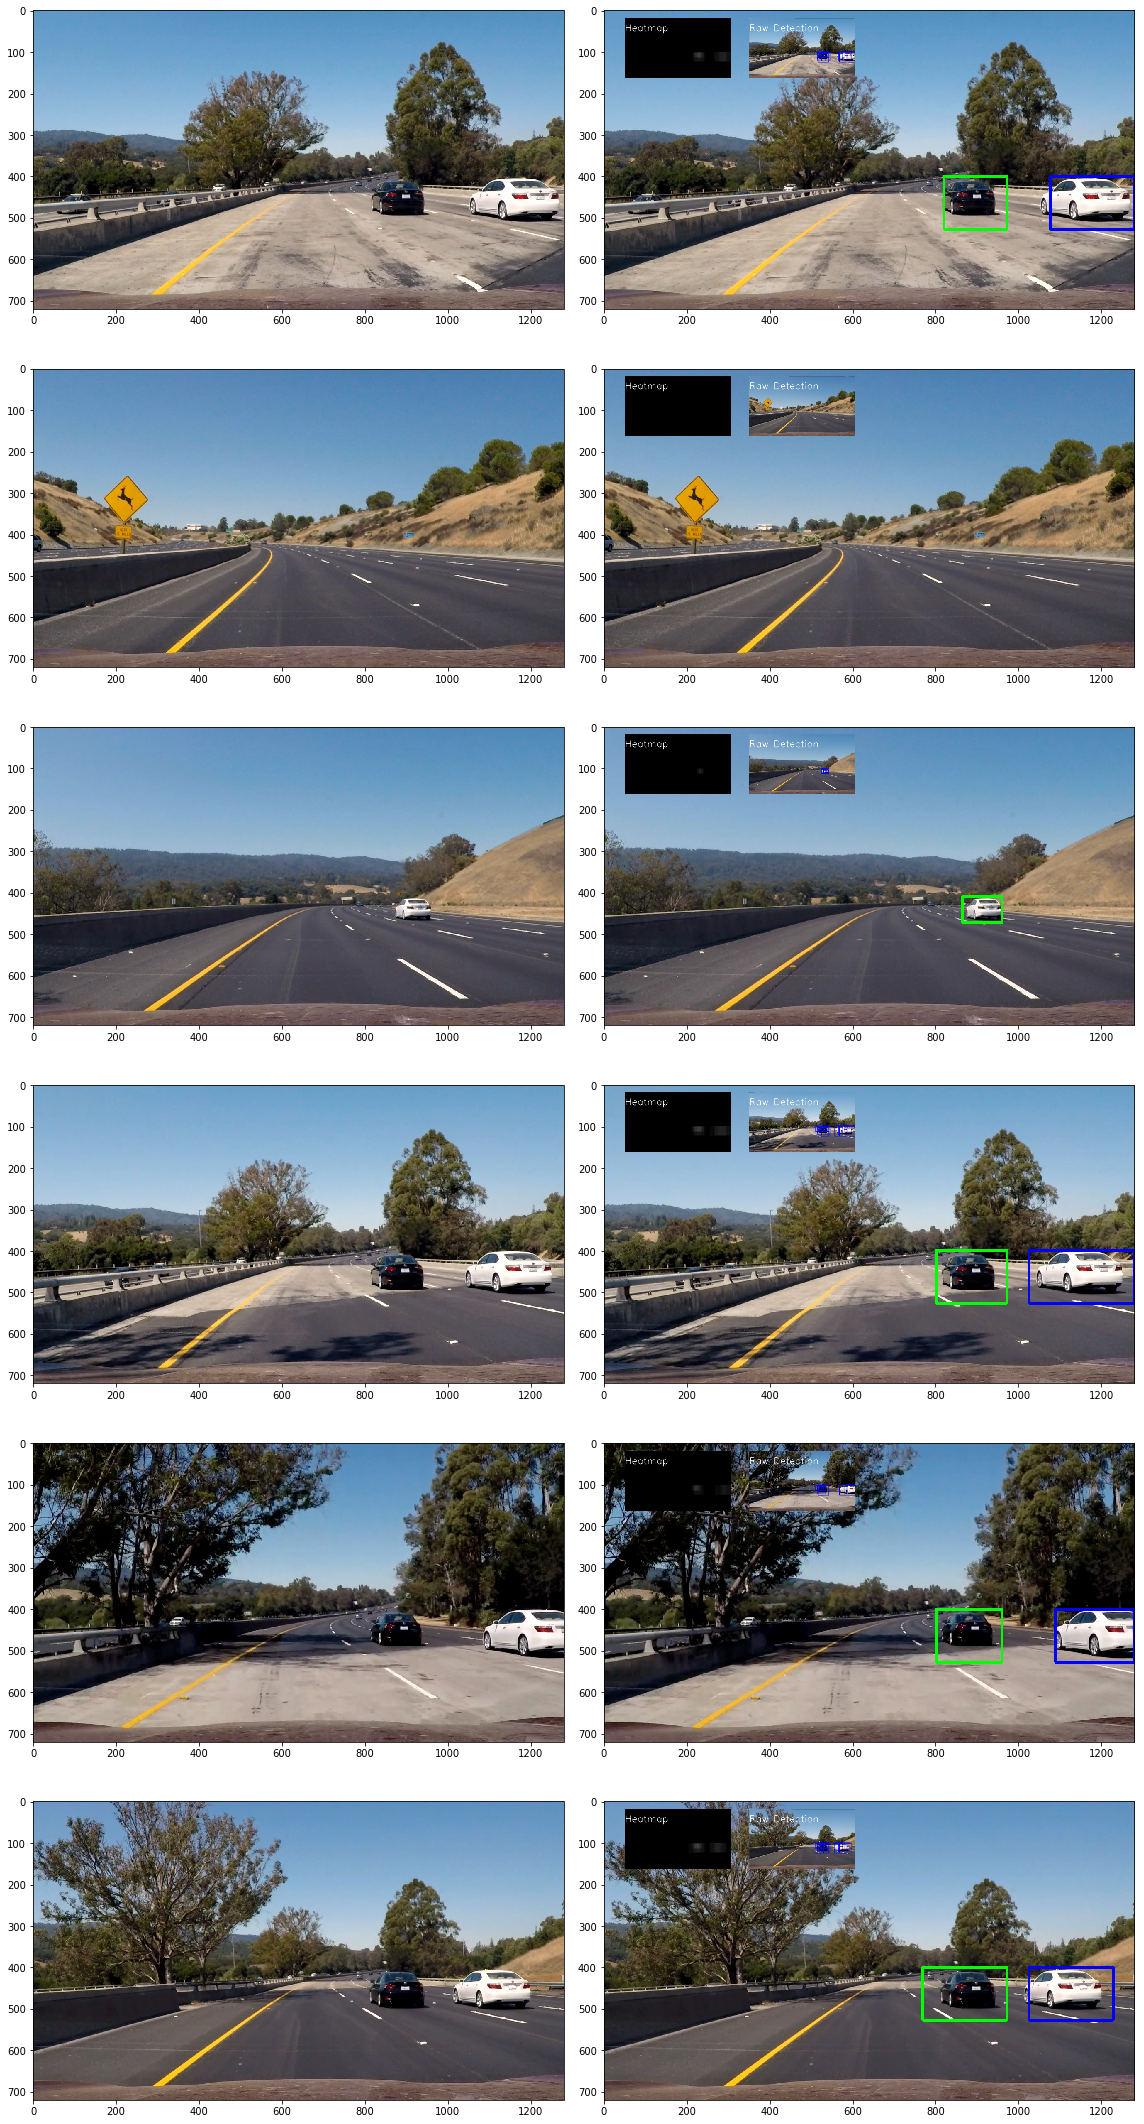

In [10]:
show_images([test_images, crude_images])


In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
count = 1
# from IPython.display import HTML

In [107]:
video_output = 'output_video\output_project_video-{}.mp4'.format(count)
count += 1
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
params = [
          # [Y-top, y-bottom, scale]
            [420, 486, .8],
            [410, 480, 1.],
            [410, 534, 1.6],
            [400, 528, 2.],
            [420, 640, 3.2]
         ]
store = Store(12)
processed_video = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)
processed_video.reader.close()
processed_video.audio.reader.close_proc()

[MoviePy] >>>> Building video output_video\output_project_video-12F_p65T-35.mp4
[MoviePy] Writing video output_video\output_project_video-12F_p65T-35.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [01:53<00:00,  1.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video\output_project_video-12F_p65T-35.mp4 

Wall time: 1min 55s
